# Análisis de vuelos
_____

# EDA

Esta es la continuación del notebook 02_limpieza_transformacion.ipynb

Es necesario utilizar el dataset que se obtuvo anteriormente para utilizar este cuaderno.

En este reporte vamos a realizar un análisis univariado y bivariado, como comparar entre las dos empresas Jetsmart y Flybondi la relación entre demoras, cantidad de vuelos, que empresa es la más eficiente.

In [224]:
mapeo_nombres = {
    'FO': 'Flybondi',
    'WJ': 'Jetsmart'
}

# Esto asegura que no se mezclen los colores de las empresas, sin importar el orden
colores_fijos = {
    'Jetsmart': '#1b365d', # Azul
    'Flybondi': '#fdbe15'  # Amarillo
}
color_g = "#fc7753"
paleta = ["#fc7753", "#66d7d1", "#C45BAA"]

## Librerías


In [225]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

def cargar_datos(ruta_archivo, **kwargs):
    """
    Carga un archivo CSV o Parquet y devuelve un DataFrame de Pandas.
    :param ruta_archivo: str, camino al archivo.
    :param kwargs: Argumentos adicionales para pd.read_csv o pd.read_parquet.
    :return: pd.DataFrame
    """
    # Extraemos la extensión del archivo
    _, extension = os.path.splitext(ruta_archivo)
    extension = extension.lower()

    try:
        if extension == '.csv':
            return pd.read_csv(ruta_archivo, **kwargs)
        elif extension == '.parquet':
            return pd.read_parquet(ruta_archivo, **kwargs)
        else:
            raise ValueError(f"Formato no soportado: {extension}. Solo CSV o Parquet.")

    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None

def graficar_frecuencias(df, columna, categoria=None, titulo=None, color='green', ordenar_por_indice=False, mostrar_media=False):
    """
    Genera un gráfico de barras con opción de mostrar la línea de media de frecuencias.
    """
    plt.figure(figsize=(10, 6))
    df_plot = df.copy()

    df_plot['empresa'] = df_plot['empresa'].map(mapeo_nombres).fillna(df_plot['empresa'])

    # 1. Definir el orden del eje X
    if ordenar_por_indice:
        order = sorted(df_plot[columna].unique())
    else:
        order = df_plot[columna].value_counts().index.astype(str)

    # 2. Creación del gráfico
    if categoria:
        ax = sns.countplot(data=df_plot, x=columna, hue=categoria, order=order, palette=colores_fijos)
        plt.legend(title=categoria, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax = sns.countplot(data=df_plot, x=columna, order=order, color=color)

    # 3. Agregar línea de media (Insight clave)
    if mostrar_media:
        # Calculamos la frecuencia de cada categoría en el eje X
        counts = df_plot[columna].value_counts()
        media = counts.mean()
        counts = df['is_cancelled'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

        # Dibujamos la línea horizontal
        plt.axhline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.1f}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 4. Estética
    plt.title(titulo if titulo else f'Distribución de {columna}' + (f' por {categoria}' if categoria else ''), fontsize=14)
    plt.xlabel(columna, fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

def graficar_evolucion(df, x, y, categoria=None, estimador='mean', titulo=None):
    """
    Grafica la evolución de una métrica con nombres reales y colores fijos.
    """

    df_plot = df.copy()
    if categoria:
        df_plot[categoria] = df_plot[categoria].map(mapeo_nombres).fillna(df_plot[categoria])

    plt.figure(figsize=(12, 5))
    sns.set_theme(style="whitegrid")

    # 3. Creación del gráfico
    plot = sns.lineplot(
        data=df_plot,
        x=x,
        y=y,
        hue=categoria,
        estimator=estimador,
        marker='o',
        linewidth=2.5,
        errorbar=None,
        palette=colores_fijos if categoria else None
    )

    # 4. Personalización de etiquetas
    label_y = y.replace('_', ' ').title()
    label_x = x.replace('_', ' ').title()

    plt.title(titulo if titulo else f'{label_y} por {label_x}', fontsize=15, pad=20)
    plt.xlabel(label_x, fontsize=12)
    plt.ylabel(f'{estimador.capitalize()} de {label_y}', fontsize=12)

    if categoria:
        plt.legend(title=categoria.replace('_', ' ').title(),
                   bbox_to_anchor=(1.05, 1), loc='upper left')

    if df_plot[x].dtype in ['int64', 'int32']:
        plt.xticks(sorted(df_plot[x].unique()))

    plt.tight_layout()
    plt.show()

def transform_column_to_datetime(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name], errors='coerce')
    return df

def show_distribution_violinplot(df, column, min_value=None, palette=None, color=color_g):
    """
    df: DataFrame
    column: Nombre de la columna a graficar
    min_value: Valor mínimo para filtrar
    palette: Nombre de paleta (ej. 'viridis', 'magma') o lista de colores
    color: Color único para el violin (ej. 'skyblue')
    """
    # 1. Filtrado de datos
    plot_data = df.copy()
    if min_value is not None:
        plot_data = plot_data[plot_data[column] > min_value]

    # 2. Configuración del gráfico
    plt.figure(figsize=(10, 6))

    sns.violinplot(
        data=plot_data,
        x=column,
        inner_kws=dict(box_width=15, whis_width=2, color=".8"),
        palette=palette,  # Se usa si quieres un degradado o varios colores
        color=color       # Se usa si prefieres un tono uniforme
    )

    plt.title(f'Distribución de {column.replace("_", " ").title()}')
    plt.show()


def ashow_distribution_violinplot(df, min_value=None):
    if min_value is not None:
        df = df[df['minutos_netos_demora'] > min_value].copy()

    sns.violinplot(
        data=df,
        x="minutos_netos_demora",
        inner_kws=dict(box_width=15, whis_width=2, color=".8")
    )

def show_custom_pie(df, column_name, labels=None, title=None, colors=None):
    # 1. Preparar los datos
    data = df[column_name].value_counts()
    n_categories = len(data)

    # 2. Manejo dinámico de etiquetas
    # Si no pasan etiquetas, usamos los índices de los datos (0, 1, etc.)
    if labels is None:
        labels = [f'{idx} ({val})' for idx, val in zip(data.index, data.values)]
    else:
        # Si pasan etiquetas, las combinamos con el conteo real
        labels = [f'{label} ({val})' for label, val in zip(labels, data.values)]

    # 3. Configuración estética dinámica
    # Si no hay colores, usamos un mapa de colores predefinido de matplotlib
    if colors is None:
        colors = plt.cm.Pastel1.colors

    # El 'explode' solo se aplica si hay al menos 2 categorías (separa la segunda)
    explode = [0.1 if i == 1 else 0 for i in range(n_categories)]

    # 4. Crear el gráfico
    plt.figure(figsize=(8, 6))
    plt.pie(
        data,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors[:n_categories], # Tomamos solo los colores necesarios
        explode=explode if n_categories > 1 else None,
        shadow=True
    )

    plt.title(title if title else f'Distribución de {column_name}', fontsize=14)
    plt.axis('equal')
    plt.show()

def graficar_impacto_temporal(df, categoria=None, unidad='dias', mostrar_etiquetas=False):
    """
    Compara el impacto de demora por mes y empresa.
    :param unidad: 'minutos', 'horas' o 'dias'.
    :param mostrar_etiquetas: bool, si es True muestra el valor sobre cada barra.
    """
    # 1. Configuración de conversión
    config = {
        'minutos': {'divisor': 1, 'label': 'Minutos Totales', 'fmt': '%.0f'},
        'horas':   {'divisor': 60, 'label': 'Horas Totales', 'fmt': '%.1f'},
        'dias':    {'divisor': 1440, 'label': 'Días de Vida Perdidos', 'fmt': '%.2f'}
    }

    if unidad not in config:
        raise ValueError("La unidad debe ser 'minutos', 'horas' o 'dias'")

    # 2. Preparación de datos
    divisor = config[unidad]['divisor']
    label_y = config[unidad]['label']
    formato = config[unidad]['fmt']

    if categoria:
        df[categoria] = df[categoria].map(mapeo_nombres).fillna(df[categoria])

    df_agrupado = df.groupby(['mes', 'empresa'])['minutos_netos_demora'].sum().reset_index()
    df_agrupado['valor_convertido'] = df_agrupado['minutos_netos_demora'] / divisor

    # 3. Creación del gráfico
    plt.figure(figsize=(14, 7))
    sns.set_theme(style="whitegrid")

    ax = sns.barplot(
        data=df_agrupado,
        x='mes',
        y='valor_convertido',
        hue='empresa',
        palette=colores_fijos if categoria else None
    )

    # 4. Opción de Data Labels
    if mostrar_etiquetas:
        # Iteramos sobre los contenedores de barras que creó Seaborn
        for container in ax.containers:
            ax.bar_label(container, fmt=formato, padding=3, fontsize=9)

    # 5. Estética
    plt.title(f'Comparativa Mensual: {label_y}', fontsize=15, pad=20)
    plt.ylabel(label_y, fontsize=12)
    plt.xlabel('Mes', fontsize=12)
    plt.legend(title='Empresa', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar margen superior para que las etiquetas no se corten
    plt.margins(y=0.15)
    plt.tight_layout()
    plt.show()

def graficar_cancelaciones_mes(dataframe, mes):
    # 1. Filtrar por mes
    df_mes = dataframe[dataframe['fecha'].dt.month == mes].copy()

    # Validar si hay datos
    if df_mes.empty:
        return f"No hay datos para el mes {mes}"

    # 2. Agrupar por día
    data_plot = df_mes.groupby('fecha')['is_cancelled'].sum().reset_index()

    # 3. Graficar
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=data_plot, x='fecha', y='is_cancelled', marker='o', color='darkred')

    # Formatear el eje X para que solo muestre el día del mes
    plt.title(f'Cancelaciones en el Mes {mes}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


## Cargar el dataset
Cargamos el dataset y vemos lo que contiene.

In [226]:
df = cargar_datos("vuelos_historicos_consolidado.parquet")
df.tail(5)

,Vuelo,Ruta,Hora Programada,Hora Real,Demora en despegar,fecha,mes,empresa,minutos_netos_demora,status,is_cancelled,franja_horaria,nivel_demora
43826,FO 5954,Ezeiza → Florianopolis,2026-02-11 08:05:00,08:22,17min tarde,2025-12-31,12,FO,17.0,Delayed,False,8,Demora Media (15-45m)
43827,FO 5210,Ezeiza → Tucuman,2026-02-11 07:00:00,07:16,16min tarde,2025-12-31,12,FO,16.0,Delayed,False,7,Demora Media (15-45m)
43828,FO 5091,Posadas → Ezeiza,2026-02-11 14:25:00,14:40,15min tarde,2025-12-31,12,FO,15.0,Delayed,False,14,Demora Leve (0-15m)
43829,FO 5103,Iguazú → Aeroparque,2026-02-11 05:35:00,05:45,10min tarde,2025-12-31,12,FO,10.0,Delayed,False,5,Demora Leve (0-15m)
43830,FO 5102,Aeroparque → Iguazú,2026-02-11 03:15:00,03:17,2min tarde,2025-12-31,12,FO,2.0,Delayed,False,3,Demora Leve (0-15m)


In [227]:
df.dtypes

,0
Vuelo,object
Ruta,object
Hora Programada,datetime64[ns]
Hora Real,object
Demora en despegar,object
fecha,object
mes,int64
empresa,object
minutos_netos_demora,float64
status,object


In [228]:
df = transform_column_to_datetime(df, "fecha")

# Análisis Univariado

Vamos a ver el estado de vuelos en general.

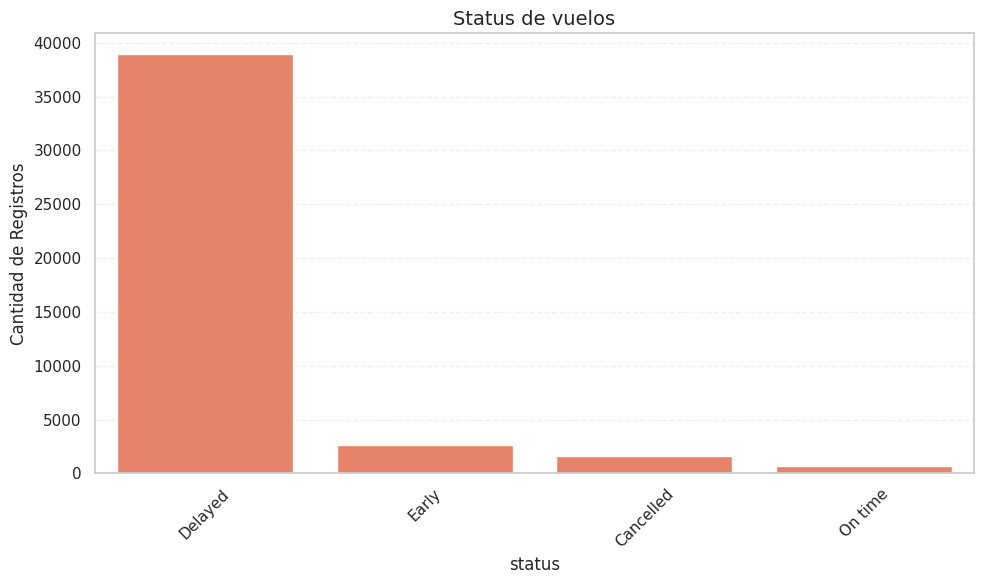

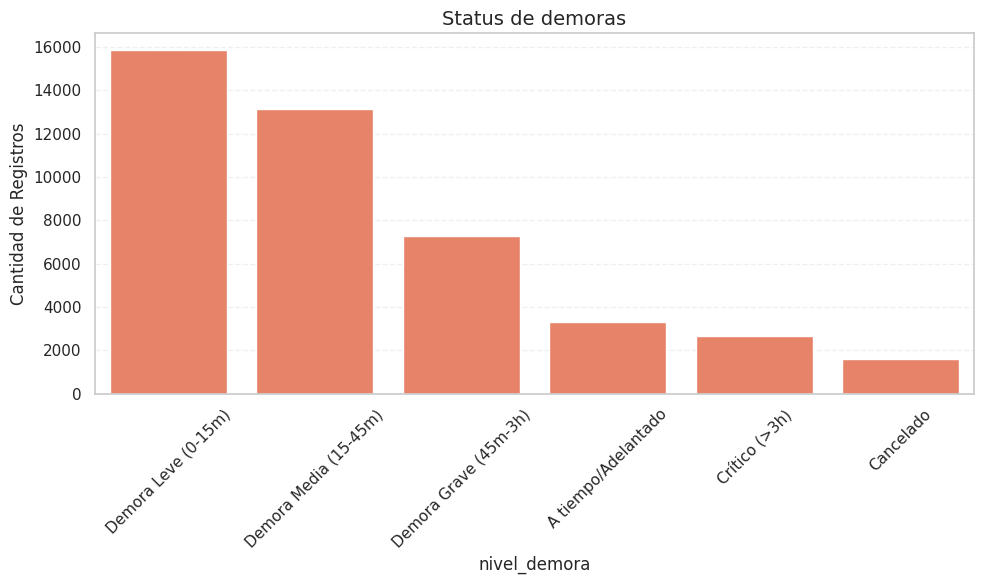

In [229]:
graficar_frecuencias(df, 'status', color=color_g, titulo='Status de vuelos')
graficar_frecuencias(df, 'nivel_demora', color=color_g, titulo='Status de demoras')

Se puede ver que la cantidad de vuelos con demora leve y media supera en gran proporción a los demas vuelos.
También se puede ver que los vuelos cancelados son inferiores a los vuelos con una demora "Crítico > 3h"

En el siguiente gráfico veremos como se distribuyen los datos según los minutos de demora.

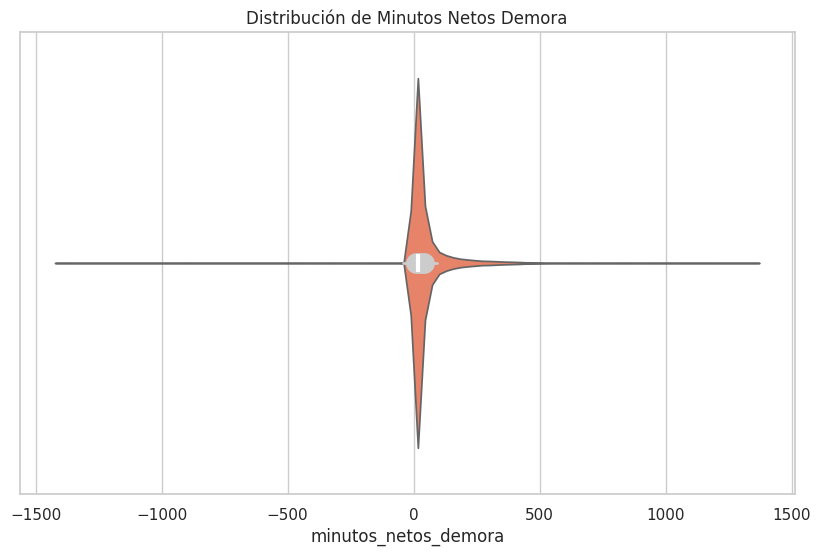

In [230]:
# show_distribution_violinplot(df)
show_distribution_violinplot(df, "minutos_netos_demora", color=color_g)

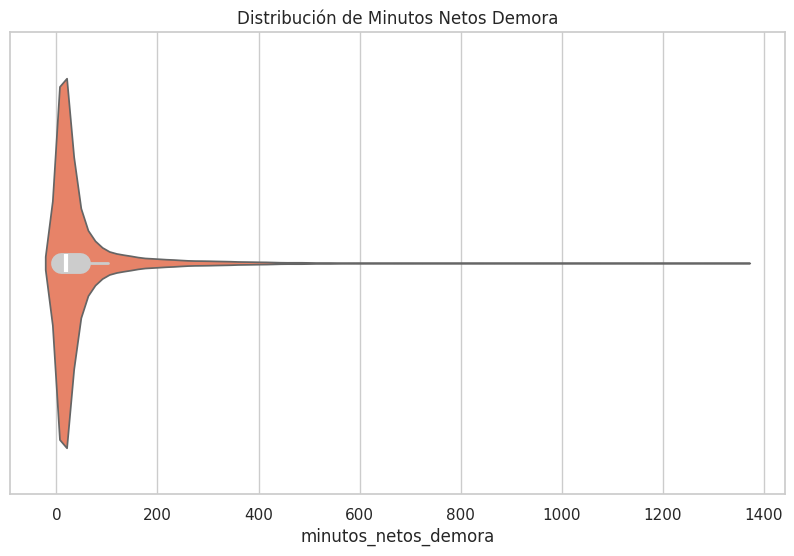

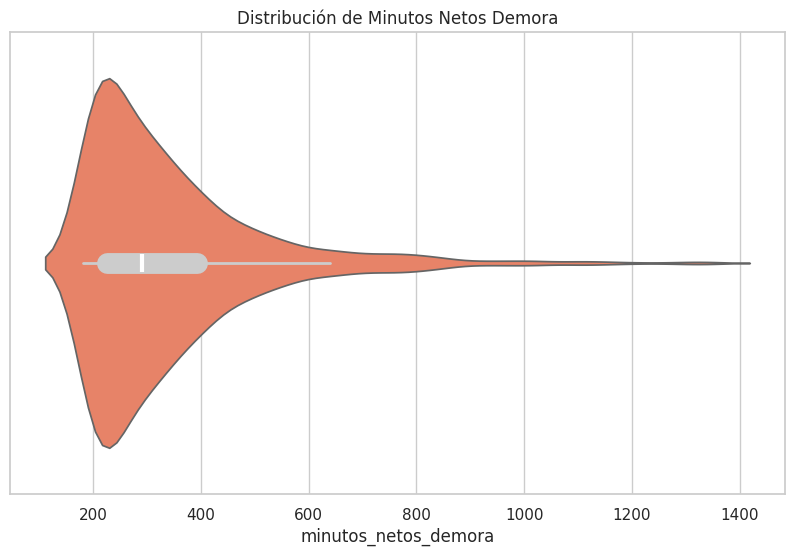

In [231]:
show_distribution_violinplot(df, "minutos_netos_demora", min_value=0)
show_distribution_violinplot(df, "minutos_netos_demora", min_value=180)


Con el gráfico de violinplot podemos ver cómo se distribuyen los valores de minutos de demora. El valor de 1400 equivalen a más de 23 horas de demora. La mayor concentración se encuentra entre los 0 minutos y los 400 minutos.

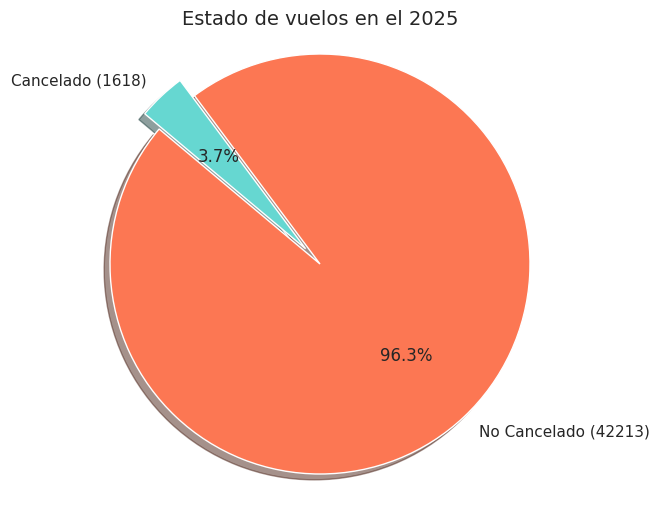

In [232]:
show_custom_pie(df, 'is_cancelled', labels=["No Cancelado", "Cancelado"], title="Estado de vuelos en el 2025", colors=paleta )

La cantidad de vuelos cancelados es mucho menor.

# Análisis Bivariado

Vamos a comparar las empresas "Jetsmart" y "Flybondi" como fue su desempeño en vuelos cancelados y con demoras. La evolución de mes a mes.

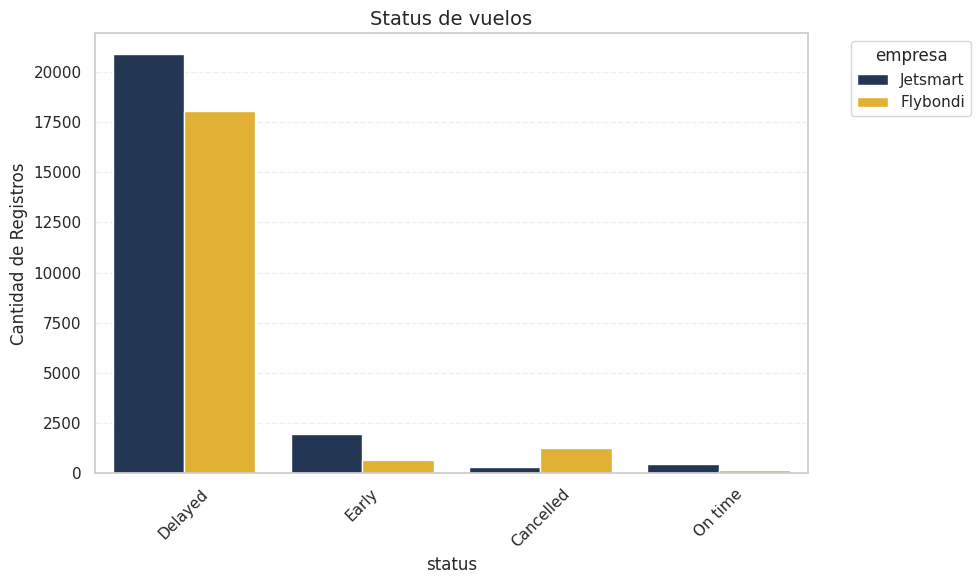

In [233]:
graficar_frecuencias(df, 'status', categoria="empresa", titulo='Status de vuelos')

Se puede ver que la empresa Jetsmart posee más retrasos en vuelos, pero en la empresa Flybondi posee mayor cantidad de vuelos cancelados.

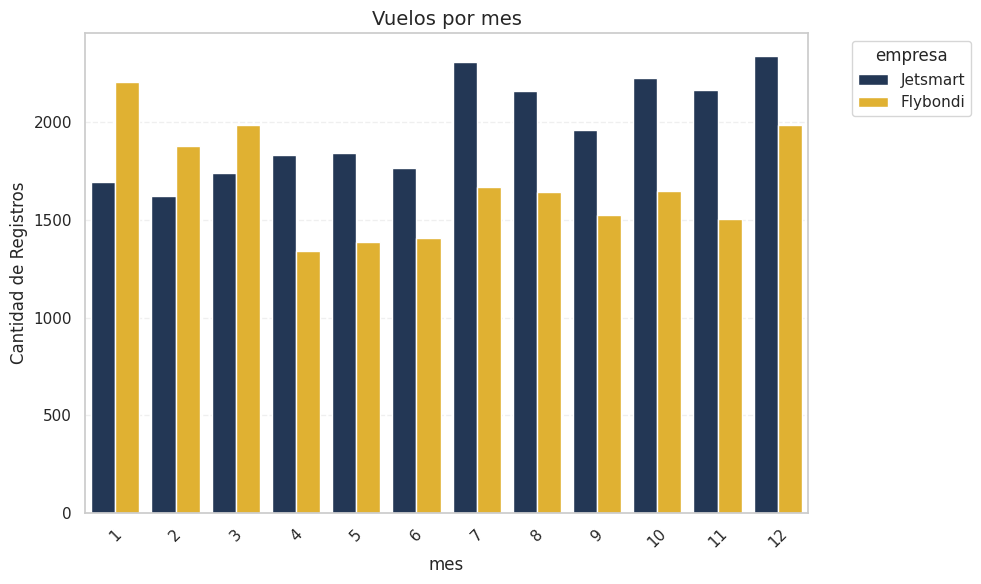

In [234]:
graficar_frecuencias(df, 'mes', categoria="empresa", titulo='Vuelos por mes', ordenar_por_indice=True)

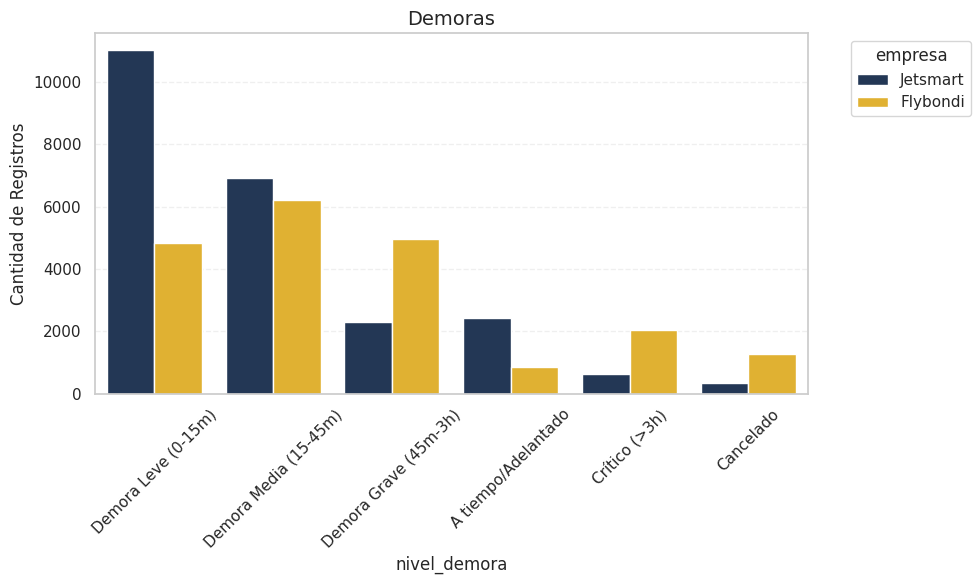

In [235]:
graficar_frecuencias(df, 'nivel_demora', categoria="empresa", titulo='Demoras')

La empresa de "Jetsmart" posee mayor cantidad de vuelos con Demora Leve y Demora Media. En cambio las demoras de más de 45 minutos se encuentra la empresa de Flybondi.

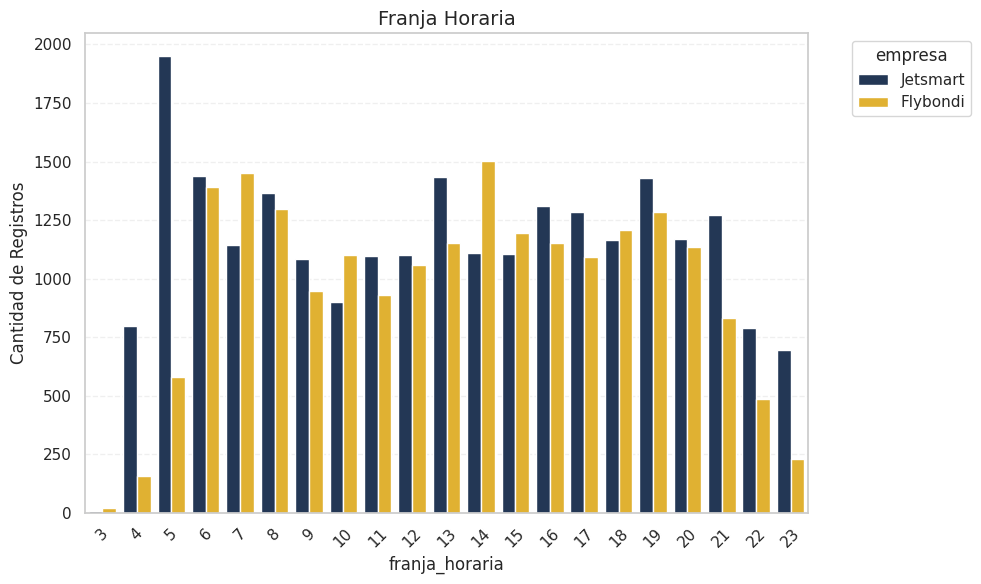

In [236]:
graficar_frecuencias(df, 'franja_horaria', categoria="empresa", titulo='Franja Horaria', ordenar_por_indice=True)

A las 5 se encuentra la mayor cantidad de vuelos de la empresa "Jetsmart"

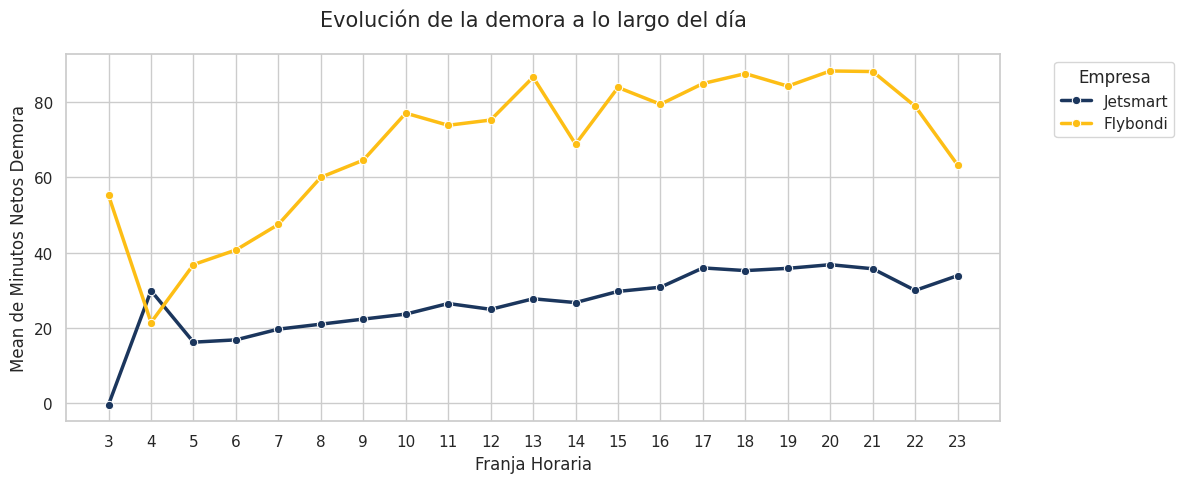

In [237]:
graficar_evolucion(df, 'franja_horaria', 'minutos_netos_demora', categoria="empresa", estimador='mean', titulo='Evolución de la demora a lo largo del día')


Alrededor de las 4 de la mañana se puede ver en la empresa de Flybondi tiene valores mínimos, ya más adelante la demora sigue creciendo, esto puede deberse a que cada vez se acumulan las demoras. En la empresa de Jetsmart tiene el primer máximo a las 4 am, pero luego se estabiliza esto puede deberse a que las demoras son leves, y no implica mucho retraso en los vuelos siguientes.

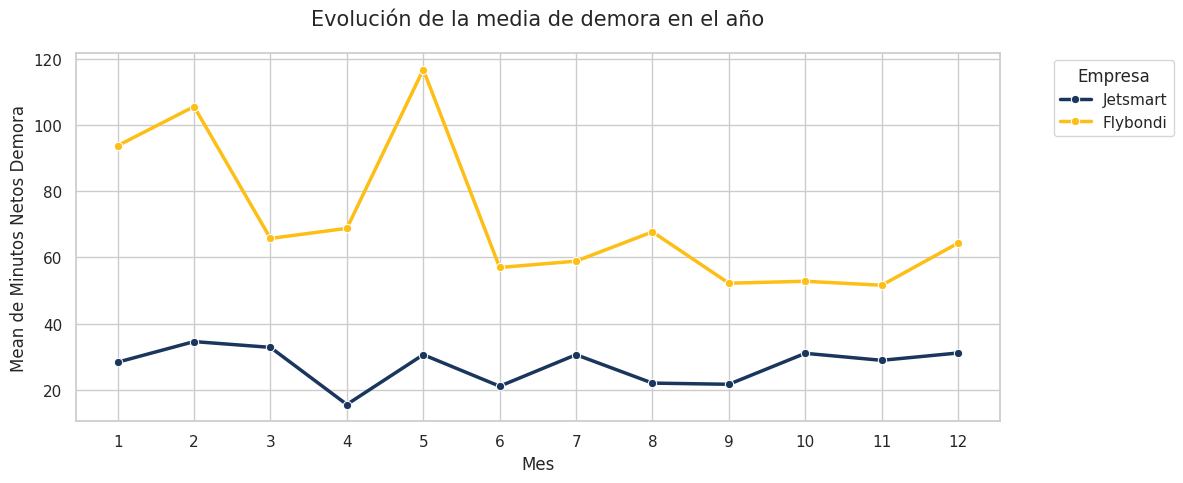

In [238]:
graficar_evolucion(df, 'mes', 'minutos_netos_demora', categoria="empresa", estimador='mean', titulo='Evolución de la media de demora en el año')


Viendo la evolución de la media de minutos de demora se puede ver que en el mes de enero, febrero y Mayo se encuentran los puntos más altos de la empresa de Flybondi.

De la Jetsmart podemos observar que en el mes de abril posee valor mínimo de la media.

Se puede apreciar la diferencia entre las dos empresas, una posee una media de demora mayor. Esta información nos da una idea que al viajar con la primer empresa podremos tener una espera más larga.

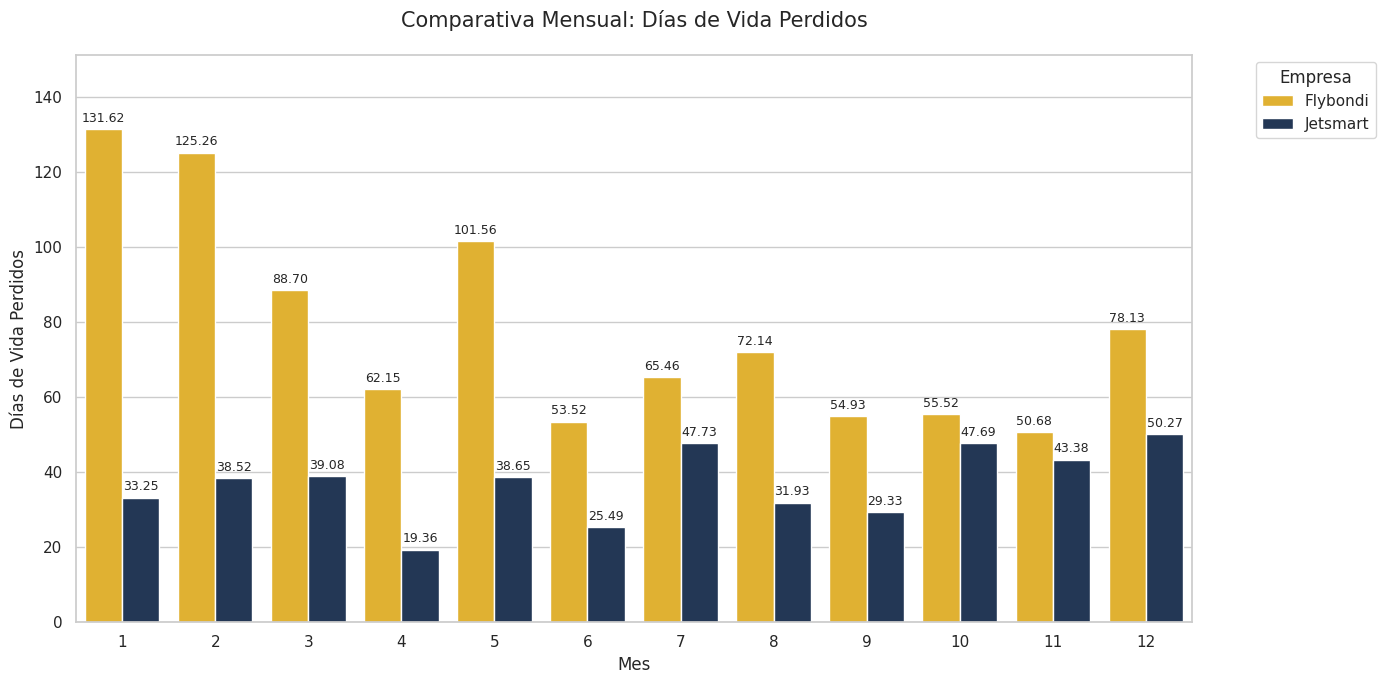

In [241]:
graficar_impacto_temporal(df,categoria="empresa", unidad='dias', mostrar_etiquetas=True)
# mejorar la funcion omitiendo codigo repetido

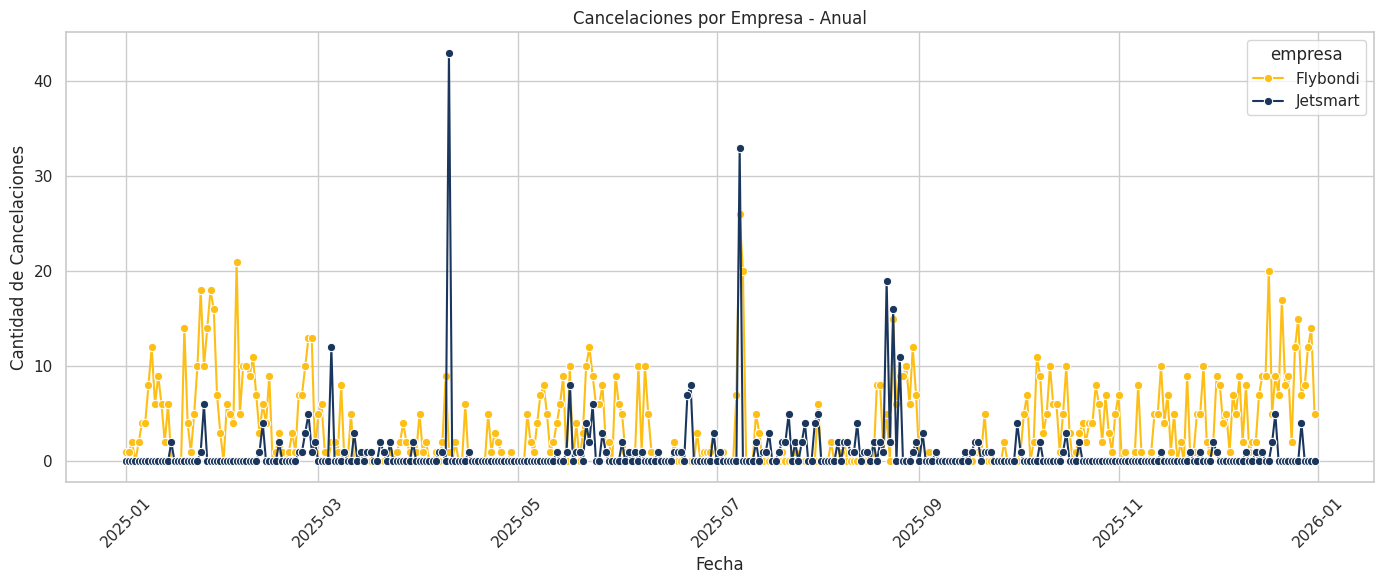

In [252]:
def graficar_cancelaciones(df, color=color_g, por_empresa=False, mes=None):
    """
    df: DataFrame procesado.
    color: Color para el gráfico general.
    colores_fijos: Diccionario {empresa: color}.
    por_empresa: Boolean, si True separa las líneas por la columna 'empresa'.
    mes: Int (1-12), si se especifica filtra el dataset por ese mes.
    """
    df_plot = df.copy()

    # 1. Asegurar formato de fecha
    df_plot['fecha'] = pd.to_datetime(df_plot['fecha'])

    # 2. Filtrado por mes (opcional)
    if mes:
        df_plot = df_plot[df_plot['fecha'].dt.month == mes]
        nombre_mes = df_plot['fecha'].dt.month_name().iloc[0] if not df_plot.empty else ""
        titulo_extra = f" - Mes: {nombre_mes}"
    else:
        titulo_extra = " - Anual"

    # 3. Agrupación lógica
    columnas_agrupar = ['fecha', 'empresa'] if por_empresa else ['fecha']
    data_agrupada = df_plot.groupby(columnas_agrupar)['is_cancelled'].sum().reset_index()

    # 4. Configuración de Visualización
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    if por_empresa:
        # Si no hay colores fijos, Seaborn usará su paleta por defecto
        plot = sns.lineplot(
            data=data_agrupada,
            x='fecha',
            y='is_cancelled',
            hue='empresa',
            palette=colores_fijos,
            marker='o'
        )
        plt.title(f'Cancelaciones por Empresa{titulo_extra}')
    else:
        sns.lineplot(
            data=data_agrupada,
            x='fecha',
            y='is_cancelled',
            color=color_g,
            marker='o'
        )
        plt.title(f'Evolución Total de Cancelaciones{titulo_extra}')

    plt.ylabel('Cantidad de Cancelaciones')
    plt.xlabel('Fecha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

graficar_cancelaciones(df, por_empresa=True)

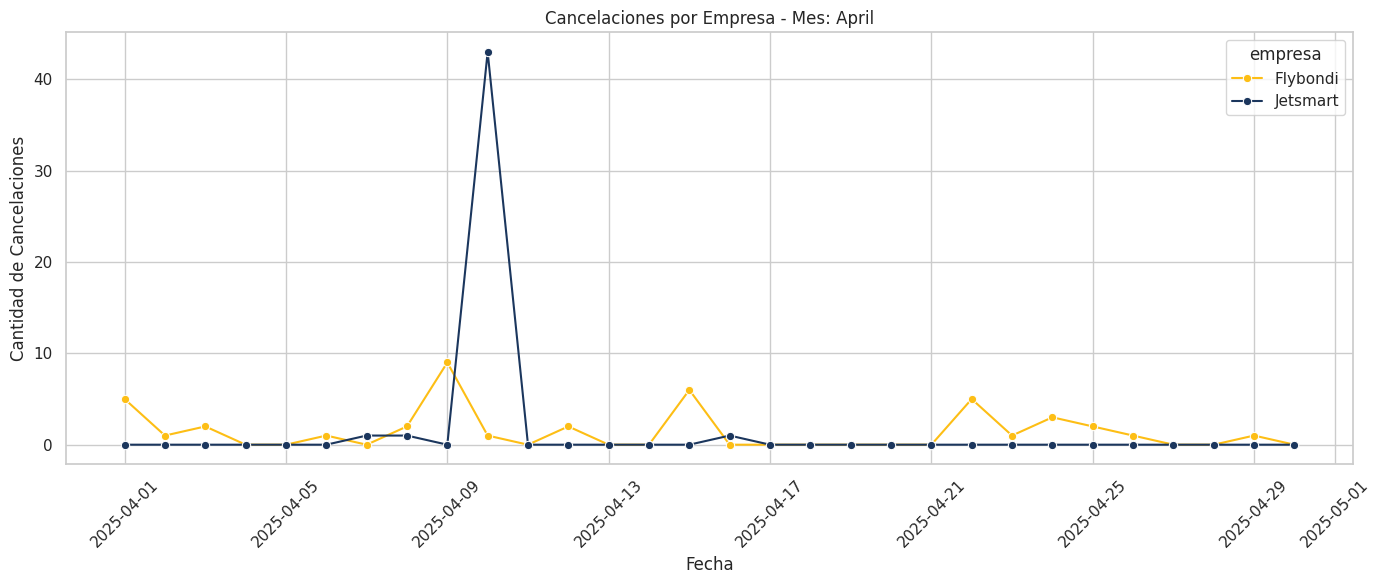

In [253]:
graficar_cancelaciones(df, por_empresa=True, mes=4)


Se puede apreciar que los vuelos del 10 de abril se encuentran un pico de vuelos cancelados.
Buscando más información sobre el estado de los vuelos de esa fecha encontre que hubo un paro general en la Argentina afectando a los vuelos de la empresa.

Link https://www.infobae.com/economia/2025/04/08/paro-general-que-pasara-con-los-vuelos-este-jueves/

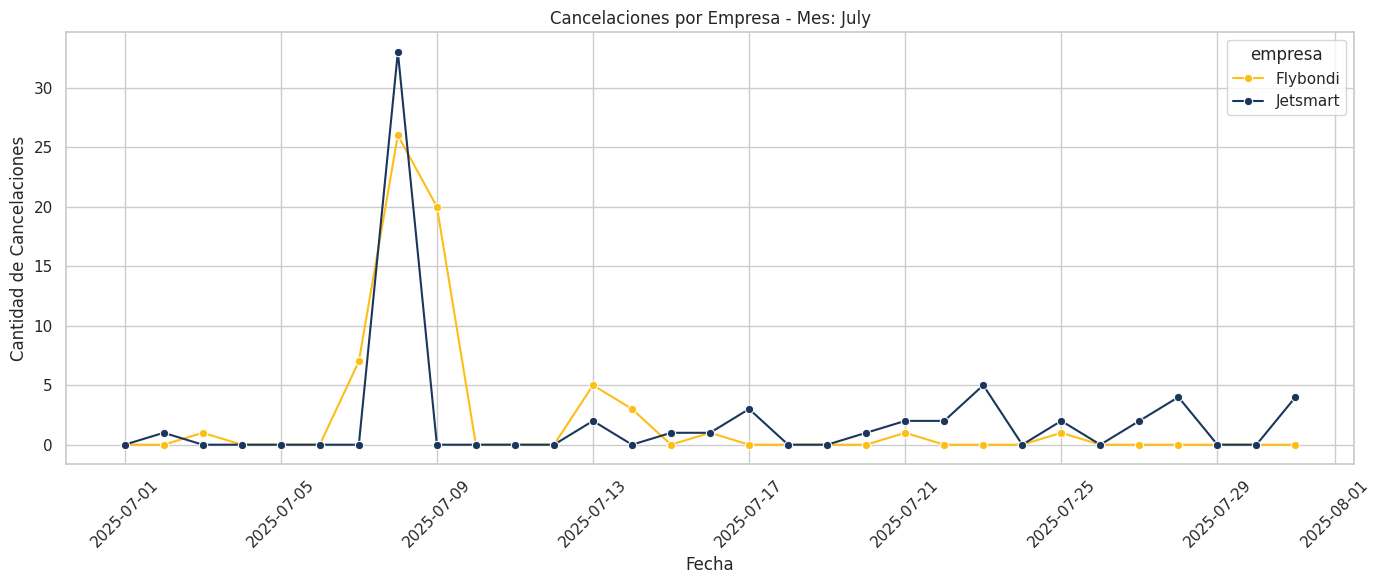

In [254]:
graficar_cancelaciones(df, por_empresa=True, mes=7)


El dia 8 de julio las aerolíneas tuvieron que posponer y cancelar muchos vuelos debido a una niebla en los aeropuertos de Buenos Aires.

Este dato es importante a la hora de analizar las cancelaciones de vuelos, no es algo que se pueda preveer con mucha anticipación, siendo julio el mes de vacaciones de invierno la cantidad de vuelos es mayor.

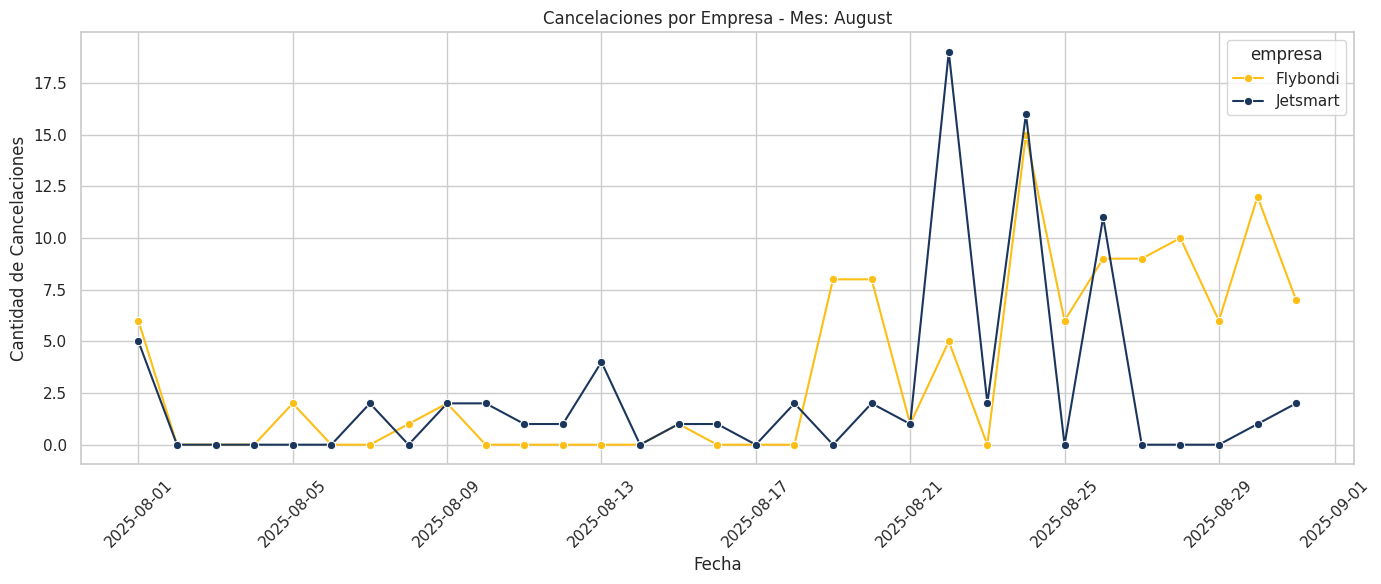

In [255]:
graficar_cancelaciones(df, por_empresa=True, mes=8)


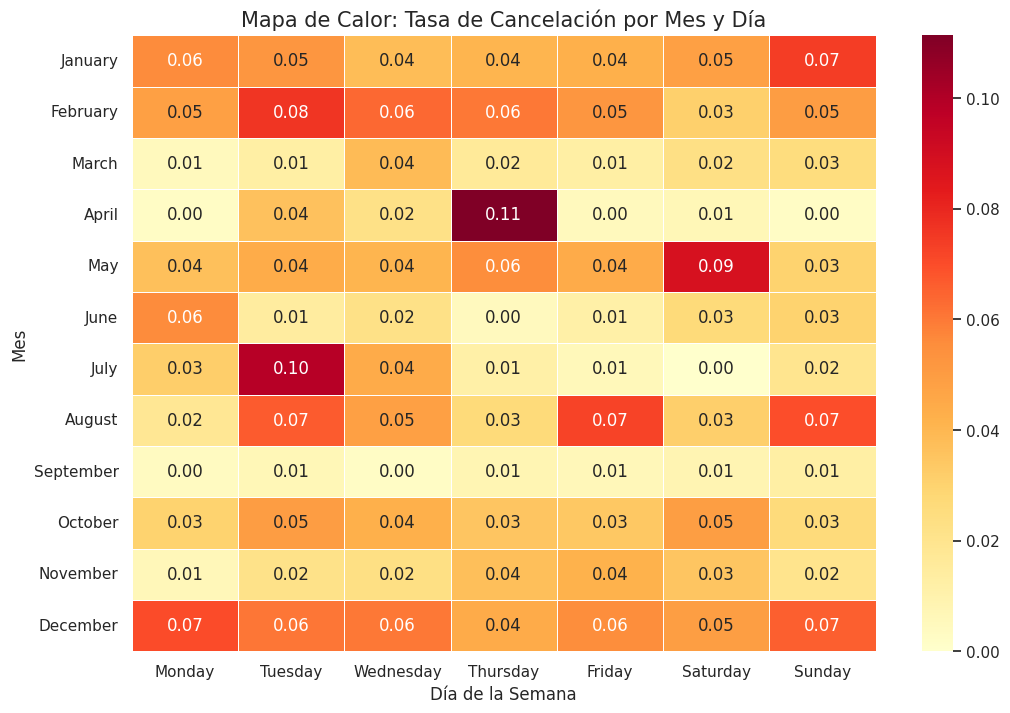

In [248]:
def heatmap_cancelaciones(dataframe):
    # 1. Preparar los datos: Extraer mes y día de la semana
    df_heat = dataframe.copy()
    df_heat['Mes'] = df_heat['fecha'].dt.month_name()
    df_heat['Dia_Semana'] = df_heat['fecha'].dt.day_name()

    # 2. Ordenar correctamente los meses y días (para que no salgan alfabéticos)
    orden_meses = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # 3. Crear tabla pivote: Media de cancelaciones (Tasa de cancelación)
    # Usamos mean() para ver la probabilidad/intensidad
    pivot_table = df_heat.pivot_table(
        values='is_cancelled',
        index='Mes',
        columns='Dia_Semana',
        aggfunc='mean'
    )

    # Reordenar filas y columnas
    pivot_table = pivot_table.reindex(index=orden_meses, columns=orden_dias)

    # 4. Visualización
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt=".2f", linewidths=.5)

    plt.title('Mapa de Calor: Tasa de Cancelación por Mes y Día', fontsize=15)
    plt.xlabel('Día de la Semana')
    plt.ylabel('Mes')
    plt.show()

# Ejecutar la función
heatmap_cancelaciones(df)

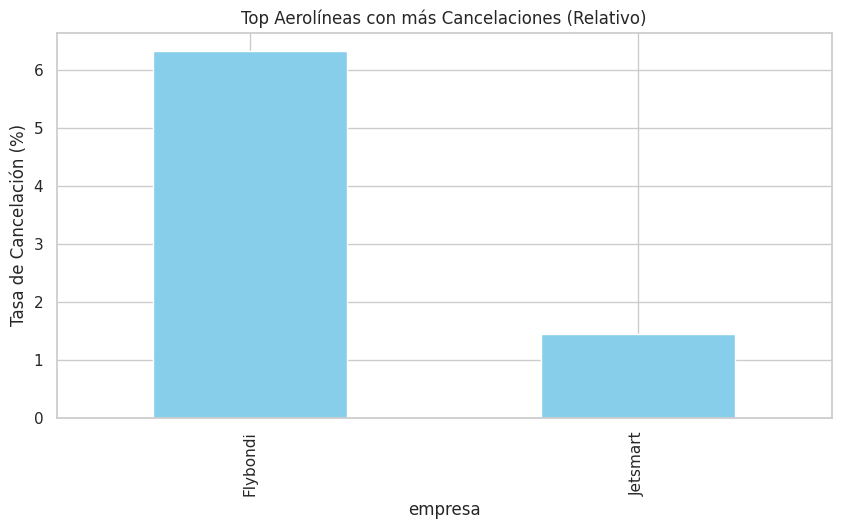

In [257]:
# Calcular tasa por empresa
tasa_aerolinea = df.groupby('empresa')['is_cancelled'].mean().sort_values(ascending=False) * 100

# Visualización
tasa_aerolinea.plot(kind='bar', color='skyblue', figsize=(10, 5))
plt.ylabel('Tasa de Cancelación (%)')
plt.title('Top Aerolíneas con más Cancelaciones (Relativo)')
plt.show()

In [251]:
# Agrupamos por ruta (Origen-Destino)
ruta_critica = df.groupby('Ruta').agg({
    'minutos_netos_demora': 'mean',
    'is_cancelled': 'mean',
    'empresa': 'count' # Para saber cuántos vuelos totales tiene esa ruta
}).rename(columns={'empresa': 'total_vuelos'})

# Filtramos rutas con un volumen mínimo de vuelos para que el dato sea estadísticamente relevante
ruta_critica = ruta_critica[ruta_critica['total_vuelos'] > 10].sort_values(by='minutos_netos_demora', ascending=False)

print(ruta_critica.head(10))

                          minutos_netos_demora  is_cancelled  total_vuelos
Ruta                                                                      
Posadas → Ezeiza                    157.866667      0.090909            33
Sgo. del Estero → Ezeiza            118.781250      0.000000            32
Mendoza → Córdoba                   118.181818      0.241379            29
Córdoba → Mendoza                   104.583333      0.225806            31
San Juan → Ezeiza                   100.121951      0.046512            43
Córdoba → Ezeiza                     99.269737      0.044025           159
Jujuy → Ezeiza                       95.881410      0.057402           331
Córdoba → Iguazú                     85.500000      0.000000            16
San Juan → Aeroparque                83.849741      0.102326           215
Aeroparque → Jujuy                   83.055394      0.055096           363
